In [ ]:
#!pip install louvain
#!pip install wishbone_dev
#!pip install PhenoGraph
#!pip install scanpy
#!pip install scprep

*Source of untreated and BCR treated data: Bendall, S. C., Simonds, E. F., Qiu, P., Amir, e., Krutzik, P. O., Finck, R., Bruggner, R. V., Melamed, R., Trejo, A., Ornatsky, O. I., Balderas, R. S., Plevritis, S. K., Sachs, K., Pe'er, D., Tanner, S. D., & Nolan, G. P. (2011). Single-cell mass cytometry of differential immune and drug responses across a human hematopoietic continuum. Science (New York, N.Y.), 332(6030), 687–696. https://doi.org/10.1126/science.1198704*

*Special thanks to Paula Josefine Schultheiss for her kind assistance in preporcessing the data and analysis the data using Wishbone.*

### Setting Up the Environment...

In [ ]:
# import modules
import numpy as np
import pandas as pd
from scipy.io import mmread
from collections import defaultdict, Counter, OrderedDict
import scanpy as sc
import scprep
import math
import scipy
import wishbone
import louvain

# Plotting imports
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
import umap
from sklearn.linear_model import LinearRegression, ElasticNet

%matplotlib inline


In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
#results_file = './write/paga.h5ad'

-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.1
-----
PIL                                 7.1.2
absl                                NA
anndata                             0.7.6
astor                               0.8.1
astunparse                          1.6.3
bhtsne                              NA
bhtsne_wrapper                      NA
bottleneck                          1.3.2
certifi                             2020.12.05
cffi                                1.14.5
chardet                             3.0.4
cloudpickle                         1.3.0
cycler                              0.10.0
cython_runtime                      NA
dask                                2.12.0
dateutil                            2.8.1
debugpy                             1.0.0
decorator                           4.4.2
dill                                0.3.3
fcsparser                           0.2.1
fe17a9cb4bdaf05853229027e5fef937    NA
flatbuffers                         NA
gast                

In [ ]:
'''
marrow_basal_file = 'C:/Users/coihu/OneDrive/Desktop/Classes/spring_2021_classes/ML_genomics/Final_Project/Marrow1_01_Basal1.fcs'
marrow_bcr_file   = 'C:/Users/coihu/OneDrive/Desktop/Classes/spring_2021_classes/ML_genomics/Final_Project/Marrow1_06_BCR.fcs'

# using the cytoflow package
basal_tube = flow.Tube(file = marrow_basal_file,
                  conditions = {'bcr' : 0.0})
bcr_tube   = flow.Tube(file=marrow_bcr_file,
                  conditions = {'bcr' : 1.0})

import_op = flow.ImportOp(conditions = {'bcr' : 'float'},
                          tubes = [basal_tube, bcr_tube])


ex = import_op.apply()
print("Channels in this experiment: \n", ex.channels)

'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import and Read Data using Wishbone

In [ ]:
marrow_basal_file = "/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/Marrow1_01_Basal1.fcs"
marrow_bcr_file = "/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/Marrow1_06_BCR.fcs"

In [ ]:
# Load sample data
scdata_basal = wishbone.wb.SCData.from_fcs(marrow_basal_file, 
                                           cofactor=None)

# Load sample data
scdata_bcr = wishbone.wb.SCData.from_fcs(marrow_bcr_file,
                                         cofactor=None)
                                         
print (type(scdata_basal)) 
print (type(scdata_bcr))                                           

<class 'wishbone.wb.SCData'>
<class 'wishbone.wb.SCData'>


In [ ]:
print("Basal data:")
scdata_basal

Basal data:


SCData: 351619 cells x 40 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

In [ ]:
print ("BCR induced data:")
scdata_bcr

BCR induced data:


SCData: 472082 cells x 40 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

The rise and fall of phenotypic markers along the resulting trajectory matched prior knowledge, **starting with CD34, followed by CD38, CD10 (the earliest canonical Pro/Pre-B cell marker), CD19, CD20, and ending with immunoglobulin heavy chain IgH expression, indicative of immature B cells ready to leave the marrow**. Developmental ordering was further cross-checked using biaxial plots. Examining ten percentile slices of cells, as ordered across the trajectory, demonstrated the expected progression (red arrows) of phenotypic markers CD34/38, CD10/19, and CD20/IgH

### Filtered B Cell subset are CD19, CD20, CD38 positive cells

### Import and read data into Scanpy and Wishbone

In [ ]:
data_dir = 'C:/Users/coihu/OneDrive/Desktop/Classes/spring_2021_classes/ML_genomics/Final_Project/'

In [ ]:
untreated_dir = '/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_sign_untr.csv'
treated_dir = '/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_trtd_sign_BCR.csv'

### **For Scanpy**

In [ ]:
basal_adata = sc.read_csv(untreated_dir)
bcr_adata = sc.read_csv(treated_dir)

In [ ]:
print('basal_adata:')
basal_adata

basal_adata:


AnnData object with n_obs × n_vars = 14516 × 23

In [ ]:
print('bcr_adata:')
bcr_adata

bcr_adata:


AnnData object with n_obs × n_vars = 15644 × 23

### **For Wishbone**

In [ ]:
basal_pd = pd.read_csv(untreated_dir)
bcr_pd = pd.read_csv(treated_dir)

In [ ]:
basal_wishbone = wishbone.wb.SCData(basal_pd)
bcr_wishbone = wishbone.wb.SCData(bcr_pd)

In [ ]:
print('basal_wishbone:')
basal_wishbone

basal_wishbone:


SCData: 14516 cells x 23 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

In [ ]:
print('bcr_wishbone:')
bcr_wishbone

bcr_wishbone:


SCData: 15644 cells x 23 genes

cluster_assignments=None
data_type=True
diffusion_eigenvalues=None
diffusion_eigenvectors=None
diffusion_map_correlations=None
library_sizes=None
metadata=True
normalized=True
pca=None
tsne=None

### Examine and visualize Basal and BCR treated Bcell data

In [ ]:
basal_matrix = scdata_basal.data
print(basal_matrix)
type(basal_matrix)

        103-Viability     110-CD3  ...  Cell Length  EventNum
0           13.887588   45.619759  ...    25.911442       1.0
1            7.953281   21.776331  ...    32.389301       2.0
2           75.394386   -0.387244  ...    55.524521       3.0
3           44.809139   -1.397486  ...    43.494209       4.0
4           80.057510   23.398191  ...    51.822887       5.0
...               ...         ...  ...          ...       ...
351614      -0.034625   43.157028  ...    16.751089  351615.0
351615      -0.252663   37.999901  ...    20.473555  351616.0
351616      -0.322575  183.248810  ...    19.542938  351617.0
351617      -0.709764  229.530807  ...    37.224648  351618.0
351618      -0.666845   47.409847  ...    16.751091  351619.0

[351619 rows x 40 columns]


pandas.core.frame.DataFrame

In [ ]:
bcr_matrix = scdata_bcr.data
print(bcr_matrix)
type(bcr_matrix)

        103-Viability    110-CD3  ...  Cell Length  EventNum
0            8.443530  18.188227  ...    43.699448       1.0
1           26.631424  -0.671770  ...    50.813313       2.0
2           11.209781  53.992680  ...    28.455456       3.0
3            8.501283   4.095024  ...    28.455456       4.0
4           29.413280  24.155302  ...    38.618118       5.0
...               ...        ...  ...          ...       ...
472077      30.194551  -0.971080  ...    21.612051  472078.0
472078      18.383575  11.012589  ...    23.670341  472079.0
472079      25.359880   0.812896  ...    30.874361  472080.0
472080       1.220421   1.885703  ...    26.757780  472081.0
472081      12.433750   0.335736  ...    22.641199  472082.0

[472082 rows x 40 columns]


pandas.core.frame.DataFrame

In [ ]:
print ("basal_matrix.columns", basal_matrix.columns)
print ("bcr_matrix.columns", bcr_matrix.columns)

basal_matrix.columns Index(['103-Viability', '110-CD3', '110_114-CD3', '111-CD3', '112-CD3',
       '114-CD3', '115-CD45', '139-CD45RA', '141-pPLCgamma2', '142-CD19',
       '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '150-pSTAT5',
       '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2',
       '156-pZAP70/Syk', '158-CD33', '159-pSTAT3', '160-CD123', '164-pSLP-76',
       '165-pNFkB', '166-IkBalpha', '167-CD38', '168-pH3', '169-pP38',
       '170-CD90', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL',
       '176-pCREB', '191-DNA', '193-DNA', 'Cell Length', 'EventNum'],
      dtype='object')
bcr_matrix.columns Index(['103-Viability', '110-CD3', '110_114-CD3', '111-CD3', '112-CD3',
       '114-CD3', '115-CD45', '139-CD45RA', '141-pPLCgamma2', '142-CD19',
       '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '150-pSTAT5',
       '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2',
       '156-pZAP70/Syk', '158-CD33', '159-pSTAT3', '160-CD123', '

In [ ]:
basal_matrix.index
basal_cells = basal_matrix.index.to_numpy()
basal_genes = basal_matrix.columns.to_numpy()
basal_genes_df = pd.DataFrame(basal_genes)
print(basal_genes)
print(basal_genes.shape)
print(basal_cells)
print(basal_matrix)

['103-Viability' '110-CD3' '110_114-CD3' '111-CD3' '112-CD3' '114-CD3'
 '115-CD45' '139-CD45RA' '141-pPLCgamma2' '142-CD19' '144-CD11b' '145-CD4'
 '146-CD8' '147-CD20' '148-CD34' '150-pSTAT5' '151-pERK1/2' '152-Ki67'
 '153-pMAPKAPK2' '154-pSHP2' '156-pZAP70/Syk' '158-CD33' '159-pSTAT3'
 '160-CD123' '164-pSLP-76' '165-pNFkB' '166-IkBalpha' '167-CD38' '168-pH3'
 '169-pP38' '170-CD90' '171-pBtk/Itk' '172-pS6' '174-pSrcFK' '175-pCrkL'
 '176-pCREB' '191-DNA' '193-DNA' 'Cell Length' 'EventNum']
(40,)
[     0      1      2 ... 351616 351617 351618]
        103-Viability     110-CD3  ...  Cell Length  EventNum
0           13.887588   45.619759  ...    25.911442       1.0
1            7.953281   21.776331  ...    32.389301       2.0
2           75.394386   -0.387244  ...    55.524521       3.0
3           44.809139   -1.397486  ...    43.494209       4.0
4           80.057510   23.398191  ...    51.822887       5.0
...               ...         ...  ...          ...       ...
351614      -0.034

In [ ]:
bcr_matrix.index
bcr_cells = bcr_matrix.index.to_numpy()
bcr_genes = bcr_matrix.columns.to_numpy()
bcr_genes_df = pd.DataFrame(bcr_genes)
print(bcr_genes)
print(bcr_genes.shape)
print(bcr_cells)
print(bcr_matrix)

['103-Viability' '110-CD3' '110_114-CD3' '111-CD3' '112-CD3' '114-CD3'
 '115-CD45' '139-CD45RA' '141-pPLCgamma2' '142-CD19' '144-CD11b' '145-CD4'
 '146-CD8' '147-CD20' '148-CD34' '150-pSTAT5' '151-pERK1/2' '152-Ki67'
 '153-pMAPKAPK2' '154-pSHP2' '156-pZAP70/Syk' '158-CD33' '159-pSTAT3'
 '160-CD123' '164-pSLP-76' '165-pNFkB' '166-IkBalpha' '167-CD38' '168-pH3'
 '169-pP38' '170-CD90' '171-pBtk/Itk' '172-pS6' '174-pSrcFK' '175-pCrkL'
 '176-pCREB' '191-DNA' '193-DNA' 'Cell Length' 'EventNum']
(40,)
[     0      1      2 ... 472079 472080 472081]
        103-Viability    110-CD3  ...  Cell Length  EventNum
0            8.443530  18.188227  ...    43.699448       1.0
1           26.631424  -0.671770  ...    50.813313       2.0
2           11.209781  53.992680  ...    28.455456       3.0
3            8.501283   4.095024  ...    28.455456       4.0
4           29.413280  24.155302  ...    38.618118       5.0
...               ...        ...  ...          ...       ...
472077      30.194551  -0

In [ ]:
# Create anndata object to apply scanpy 
import anndata
ioncount = basal_matrix
basal_adata = anndata.AnnData(X=ioncount, obs=basal_cells)

# Create anndata object to apply scanpy 
import anndata
ioncount = bcr_matrix
bcr_adata = anndata.AnnData(X=ioncount, obs= bcr_cells)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


In [ ]:
#!pip install MulticoreTSNE
import MulticoreTSNE

computing PCA
    with n_comps=39
    finished (0:00:13)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)
computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:48:28)
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


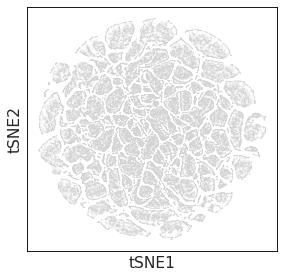

In [ ]:
# Perform Clustering analysis
sc.tl.pca(basal_adata, svd_solver='arpack')
sc.pp.neighbors(basal_adata, n_neighbors=4, n_pcs=50, method='umap', use_rep='X_pca')
sc.tl.tsne(basal_adata)
sc.pl.tsne(basal_adata)

computing PCA
    with n_comps=39
    finished (0:00:17)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (1:11:00)


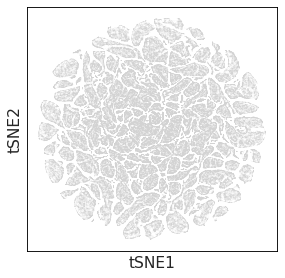

In [ ]:
# Perform Clustering analysis
sc.tl.pca(bcr_adata, svd_solver='arpack')
sc.pp.neighbors(bcr_adata, n_neighbors=4, n_pcs=50, method='umap', use_rep='X_pca')
sc.tl.tsne(bcr_adata)
sc.pl.tsne(bcr_adata)

# Select BC subset CD19, CD20, CD38 positive cells for Basal (untreated cells)

In [ ]:
surface = ['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38', '170-CD90']
signaling = ['110_114-CD3', '111-CD3', '112-CD3', '114-CD3', '141-pPLCgamma2', '150-pSTAT5', '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2', '156-pZAP70/Syk', '159-pSTAT3', '164-pSLP-76', '165-pNFkB', '166-IkBalpha', '168-pH3', '169-pP38', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL', '176-pCREB']
surfsign = surface + signaling

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


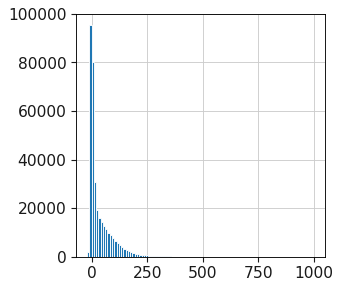

10.168265342712402
44.246929922158266
(206408, 40)


In [ ]:
#Negatively filter for CD3 (TC), CD33 (myeloid lineage), CD11b (Macrophages)
matrix_CD3 = pd.DataFrame(basal_matrix)

CD3 = matrix_CD3['114-CD3']
plt.hist(CD3, bins=100, range=[-20, 1000])
plt.show()
CD3_median = np.median(CD3)
CD3_mean = np.mean(CD3)
print(CD3_median)
print(CD3_mean)

CD3_cutoff = 20
CD3_filter = CD3.index[CD3 < CD3_cutoff]

matrix_CD3 = matrix_CD3.filter(items=CD3_filter, axis=0)
print(matrix_CD3.shape)

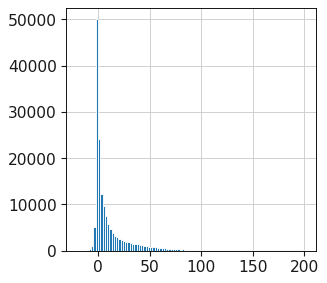

6.511331081390381
81.42113463359588
(141024, 40)


In [ ]:
#Negatively filter for CD3 (TC), CD33 (myeloid lineage), CD11b (Macrophages)
matrix_CD33 = pd.DataFrame(matrix_CD3)

CD33 = matrix_CD33['158-CD33']
plt.hist(CD33, bins=100, range=[-20, 200])
plt.show()
CD33_median = np.median(CD33)
CD33_mean = np.mean(CD33)
print(CD33_median)
print(CD33_mean)

CD33_cutoff = 30
CD33_filter = CD33.index[CD33 < CD33_cutoff]

matrix_CD33 = matrix_CD33.filter(items=CD33_filter, axis=0)
print(matrix_CD33.shape)

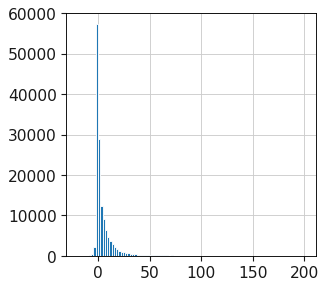

-0.040822580456733704
5.0546534273707975
(140391, 40)


In [ ]:
matrix_CD11 = pd.DataFrame(matrix_CD33)

CD11 = matrix_CD11['144-CD11b']
plt.hist(CD11, bins=100, range=[-20, 200])
plt.show()
CD11_median = np.median(CD11)
CD11_mean = np.mean(CD11)
print(CD11_median)
print(CD11_mean)

CD11_cutoff = 100
CD11_filter = CD11.index[CD11 < CD11_cutoff]

matrix_CD11 = matrix_CD11.filter(items=CD11_filter, axis=0)
print(matrix_CD11.shape)

In [ ]:
matrix_CD4 = pd.DataFrame(matrix_CD11)

CD4 = matrix_CD4['145-CD4']

CD4_cutoff = 40
CD4_filter = CD4.index[CD4 < CD4_cutoff]

matrix_CD4 = matrix_CD4.filter(items=CD4_filter, axis=0)
print(matrix_CD4.shape)

matrix_CD8 = pd.DataFrame(matrix_CD4)

CD8 = matrix_CD8['146-CD8']

CD8_cutoff = 40
CD8_filter = CD8.index[CD8 < CD8_cutoff]

matrix_CD8 = matrix_CD8.filter(items=CD8_filter, axis=0)
print(matrix_CD8.shape)

(136583, 40)
(123852, 40)


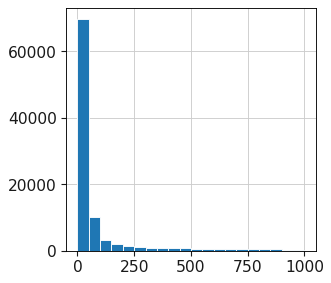

10.168265342712402


In [ ]:
# Select CD38+ cells
# Use column of CD38 marker
CD38 = matrix_CD8['167-CD38']
plt.hist(CD38, bins=20, range=[0, 1000])
plt.show()
CD38_median = np.median(CD3)
print(CD38_median)

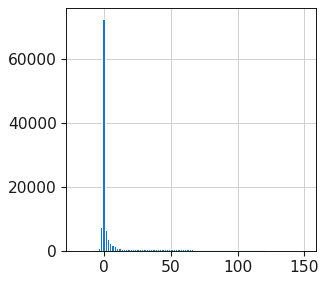

-0.2515268176794052
(25879, 40)
        103-Viability   110-CD3  ...  Cell Length  EventNum
8            8.392384 -0.072176  ...    49.046665       9.0
57         103.455429 -1.910784  ...    37.016380      58.0
86          19.245893  3.471025  ...    30.538527      87.0
105         49.244591  8.111740  ...    49.046741     106.0
128         12.192245  0.274203  ...    30.538548     129.0
...               ...       ...  ...          ...       ...
351560      80.456306  5.909548  ...    29.779690  351561.0
351561      42.837269  1.879671  ...    40.947075  351562.0
351579      32.150322  0.879912  ...    34.432777  351580.0
351582      29.214769 -0.557511  ...    27.918468  351583.0
351588      60.789875  1.310731  ...    37.224628  351589.0

[25879 rows x 40 columns]


In [ ]:
# Select CD19+ cells
# Use column of CD19 marker
CD19 = matrix_CD8['142-CD19']
plt.hist(CD19, bins=100, range=[-20, 150])
plt.show()
CD19_median = np.median(CD19)
print(CD19_median)

## apply filter
CD19_cutoff = 10
matrix_CD19 = pd.DataFrame(matrix_CD8)
CD19_filter = CD19.index[CD19 > CD19_cutoff]
matrix_CD19 = matrix_CD19.filter(items=CD19_filter, axis=0)

print(matrix_CD19.shape)

print(matrix_CD19)


In [ ]:
matrix_CD20 = pd.DataFrame(matrix_CD19)

#matrix_CD20.rename(index={0:48294})
CD20 = matrix_CD20['147-CD20']

CD20_cutoff = 10
CD20_filter = CD20.index[CD20 > CD20_cutoff]

matrix_BC_filt = matrix_CD20.filter(items=CD20_filter, axis=0)
print(matrix_BC_filt)

        103-Viability   110-CD3  ...  Cell Length  EventNum
8            8.392384 -0.072176  ...    49.046665       9.0
57         103.455429 -1.910784  ...    37.016380      58.0
86          19.245893  3.471025  ...    30.538527      87.0
105         49.244591  8.111740  ...    49.046741     106.0
128         12.192245  0.274203  ...    30.538548     129.0
...               ...       ...  ...          ...       ...
351417      12.761259 -0.667430  ...    21.404102  351418.0
351454      20.865358 -0.038190  ...    37.224548  351455.0
351561      42.837269  1.879671  ...    40.947075  351562.0
351579      32.150322  0.879912  ...    34.432777  351580.0
351582      29.214769 -0.557511  ...    27.918468  351583.0

[17230 rows x 40 columns]


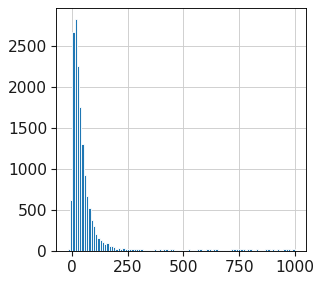

31.916990280151367


In [ ]:
# Filter for CD38+ cells
matrix_CD38 = pd.DataFrame(matrix_BC_filt)

CD38 = matrix_CD38['167-CD38']
plt.hist(CD38, bins=100, range=[-20, 1000])
plt.show()
CD38_median = np.median(CD38)
print(CD38_median)


In [ ]:
CD38_cutoff = 10
CD38_filter = CD38.index[CD38 > CD38_cutoff]

matrix_CD38 = matrix_BC_filt.filter(items=CD38_filter, axis=0)

print(matrix_CD38.shape)

(14058, 40)


In [ ]:
basal_matrix_BC = matrix_CD38
print(basal_matrix_BC)

        103-Viability   110-CD3  ...  Cell Length  EventNum
8            8.392384 -0.072176  ...    49.046665       9.0
86          19.245893  3.471025  ...    30.538527      87.0
105         49.244591  8.111740  ...    49.046741     106.0
128         12.192245  0.274203  ...    30.538548     129.0
170         16.702127 -2.697961  ...    37.941856     171.0
...               ...       ...  ...          ...       ...
351300      13.718820 -0.610062  ...    34.432625  351301.0
351334      18.780277 -0.138551  ...    56.767326  351335.0
351561      42.837269  1.879671  ...    40.947075  351562.0
351579      32.150322  0.879912  ...    34.432777  351580.0
351582      29.214769 -0.557511  ...    27.918468  351583.0

[14058 rows x 40 columns]


In [ ]:
surface = ['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38', '170-CD90']
signaling = ['110_114-CD3', '111-CD3', '112-CD3', '114-CD3', '141-pPLCgamma2', '150-pSTAT5', '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2', '156-pZAP70/Syk', '159-pSTAT3', '164-pSLP-76', '165-pNFkB', '166-IkBalpha', '168-pH3', '169-pP38', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL', '176-pCREB']
surfsign = surface + signaling
print(surfsign)

#print(type(surface))
#Surface marker matrix
basal_surf_marker = pd.DataFrame(basal_matrix_BC)
basal_surf_marker = basal_surf_marker.filter(items=surface)
#print(matrix_surf)

# Signaling marker matrix
basal_sign = pd.DataFrame(basal_matrix_BC)
basal_sign = basal_sign.filter(items=signaling)
#print(matrix_sign)

['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38', '170-CD90', '110_114-CD3', '111-CD3', '112-CD3', '114-CD3', '141-pPLCgamma2', '150-pSTAT5', '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2', '156-pZAP70/Syk', '159-pSTAT3', '164-pSLP-76', '165-pNFkB', '166-IkBalpha', '168-pH3', '169-pP38', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL', '176-pCREB']


In [ ]:
filtered_basal_matrix = pd.DataFrame(basal_matrix_BC)
filtered_basal_matrix = basal_matrix_BC.filter(items=surfsign)
print(filtered_basal_matrix)

         110-CD3    115-CD45  139-CD45RA  ...  174-pSrcFK  175-pCrkL  176-pCREB
8      -0.072176  219.463165   73.935654  ...    2.677969  -1.446438   2.424710
86      3.471025  121.284737   48.537941  ...    2.334899  -0.543340   6.949952
105     8.111740  202.971786  172.287354  ...   21.048615   6.833373  11.900854
128     0.274203  285.253662   68.100349  ...   11.121324   3.745601  -1.869049
170    -2.697961  180.863159   78.272270  ...   60.180019   2.602632  17.872478
...          ...         ...         ...  ...         ...        ...        ...
351300 -0.610062   72.708893   17.601091  ...   29.250572  10.142306  24.974667
351334 -0.138551  294.043152   81.673035  ...   10.934881   5.375485   7.010246
351561  1.879671  354.147400   87.005310  ...    8.499798   9.642488  13.837517
351579  0.879912  383.223236  252.046555  ...   17.034628   5.198264  10.117256
351582 -0.557511  356.629700   64.608337  ...   32.876179   1.093069  13.081468

[14058 rows x 35 columns]


In [ ]:
# Export matrices
basal_sign.to_csv('/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_basal_signal_markers_#2.csv')
basal_surf_marker.to_csv('/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_basal_surf_markers_#2.csv')

# transpose it

In [ ]:
#untreated_dir = '/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_sign_untr.csv'
#treated_dir = '/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_trtd_sign_BCR.csv'

# Select BC subset CD19, CD20, CD38 positive cells for BCR treated cells

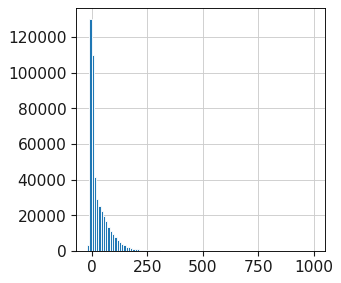

9.287399768829346
39.29096510216748
(282929, 40)


In [ ]:
#Negatively filter for CD3 (TC), CD33 (myeloid lineage), CD11b (Macrophages)
matrix_CD3 = pd.DataFrame(bcr_matrix)

CD3 = matrix_CD3['114-CD3']
plt.hist(CD3, bins=100, range=[-20, 1000])
plt.show()
CD3_median = np.median(CD3)
CD3_mean = np.mean(CD3)
print(CD3_median)
print(CD3_mean)

CD3_cutoff = 20
CD3_filter = CD3.index[CD3 < CD3_cutoff]

matrix_CD3 = matrix_CD3.filter(items=CD3_filter, axis=0)
print(matrix_CD3.shape)

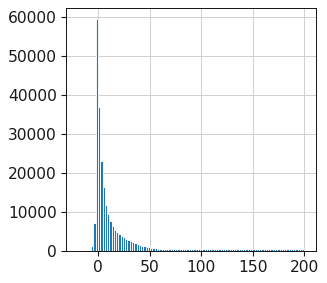

5.945684909820557
50.27396564702586
(207163, 40)


In [ ]:
#Negatively filter for CD3 (TC), CD33 (myeloid lineage), CD11b (Macrophages)
matrix_CD33 = pd.DataFrame(matrix_CD3)

CD33 = matrix_CD33['158-CD33']
plt.hist(CD33, bins=100, range=[-20, 200])
plt.show()
CD33_median = np.median(CD33)
CD33_mean = np.mean(CD33)
print(CD33_median)
print(CD33_mean)

CD33_cutoff = 30
CD33_filter = CD33.index[CD33 < CD33_cutoff]

matrix_CD33 = matrix_CD33.filter(items=CD33_filter, axis=0)
print(matrix_CD33.shape)

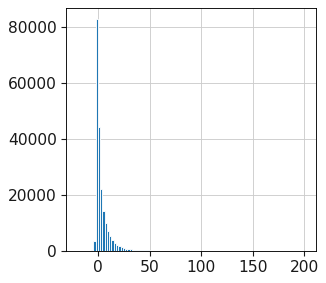

0.10437464714050293
3.7250451928751156
(206900, 40)


In [ ]:
matrix_CD11 = pd.DataFrame(matrix_CD33)

CD11 = matrix_CD11['144-CD11b']
plt.hist(CD11, bins=100, range=[-20, 200])
plt.show()
CD11_median = np.median(CD11)
CD11_mean = np.mean(CD11)
print(CD11_median)
print(CD11_mean)

CD11_cutoff = 100
CD11_filter = CD11.index[CD11 < CD11_cutoff]

matrix_CD11 = matrix_CD11.filter(items=CD11_filter, axis=0)
print(matrix_CD11.shape)

In [ ]:
matrix_CD4 = pd.DataFrame(matrix_CD11)

CD4 = matrix_CD4['145-CD4']

CD4_cutoff = 40
CD4_filter = CD4.index[CD4 < CD4_cutoff]

matrix_CD4 = matrix_CD4.filter(items=CD4_filter, axis=0)
print(matrix_CD4.shape)

matrix_CD8 = pd.DataFrame(matrix_CD4)

CD8 = matrix_CD8['146-CD8']

CD8_cutoff = 40
CD8_filter = CD8.index[CD8 < CD8_cutoff]

matrix_CD8 = matrix_CD8.filter(items=CD8_filter, axis=0)
print(matrix_CD8.shape)

(202078, 40)
(185139, 40)


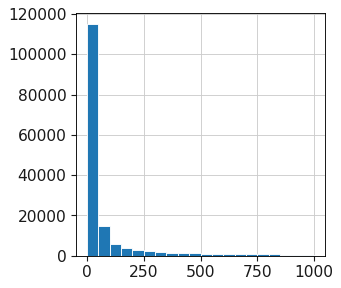

9.287399768829346


In [ ]:
# Select CD38+ cells
# Use column of CD38 marker
CD38 = matrix_CD8['167-CD38']
plt.hist(CD38, bins=20, range=[0, 1000])
plt.show()
CD38_median = np.median(CD3)
print(CD38_median)

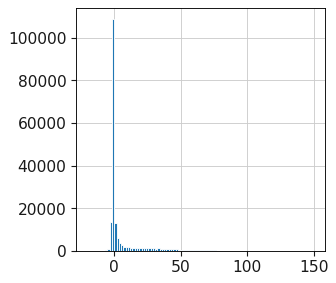

-0.28262490034103394
(32624, 40)
        103-Viability    110-CD3  ...  Cell Length  EventNum
4           29.413280  24.155302  ...    38.618118       5.0
9           59.127087   1.774363  ...    24.390394      10.0
10           4.773072  -0.437870  ...    30.487993      11.0
12          30.850716  -2.307435  ...    64.024788      13.0
15          16.987175  -0.153677  ...    29.471731      16.0
...               ...        ...  ...          ...       ...
472012       3.822484   1.715871  ...    37.049168  472013.0
472016      -0.785950  -0.438085  ...    25.728590  472017.0
472030      12.954282  -0.972769  ...    47.340626  472031.0
472054      -0.615822  -0.127428  ...    43.224075  472055.0
472079      25.359880   0.812896  ...    30.874361  472080.0

[32624 rows x 40 columns]


In [ ]:
# Select CD19+ cells
# Use column of CD19 marker
CD19 = matrix_CD8['142-CD19']
plt.hist(CD19, bins=100, range=[-20, 150])
plt.show()
CD19_median = np.median(CD19)
print(CD19_median)

## apply filter
CD19_cutoff = 10
matrix_CD19 = pd.DataFrame(matrix_CD8)
CD19_filter = CD19.index[CD19 > CD19_cutoff]
matrix_CD19 = matrix_CD19.filter(items=CD19_filter, axis=0)

print(matrix_CD19.shape)

print(matrix_CD19)


In [ ]:
matrix_CD20 = pd.DataFrame(matrix_CD19)

#matrix_CD20.rename(index={0:48294})
CD20 = matrix_CD20['147-CD20']

CD20_cutoff = 10
CD20_filter = CD20.index[CD20 > CD20_cutoff]

matrix_BC_filt = matrix_CD20.filter(items=CD20_filter, axis=0)
print(matrix_BC_filt)

        103-Viability    110-CD3  ...  Cell Length  EventNum
4           29.413280  24.155302  ...    38.618118       5.0
10           4.773072  -0.437870  ...    30.487993      11.0
12          30.850716  -2.307435  ...    64.024788      13.0
30           9.107940   1.746720  ...    46.748283      31.0
45          16.533991  -4.815868  ...    25.406685      46.0
...               ...        ...  ...          ...       ...
471976      42.876427  -0.792894  ...    56.602837  471977.0
472003      11.446501  -0.049322  ...    44.253159  472004.0
472012       3.822484   1.715871  ...    37.049168  472013.0
472030      12.954282  -0.972769  ...    47.340626  472031.0
472079      25.359880   0.812896  ...    30.874361  472080.0

[19627 rows x 40 columns]


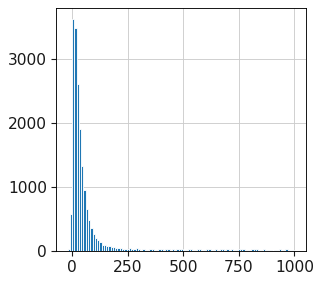

28.701858520507812


In [ ]:
# Filter for CD38+ cells
matrix_CD38 = pd.DataFrame(matrix_BC_filt)

CD38 = matrix_CD38['167-CD38']
plt.hist(CD38, bins=100, range=[-20, 1000])
plt.show()
CD38_median = np.median(CD38)
print(CD38_median)


In [ ]:
CD38_cutoff = 10
CD38_filter = CD38.index[CD38 > CD38_cutoff]

matrix_CD38 = matrix_BC_filt.filter(items=CD38_filter, axis=0)

print(matrix_CD38.shape)

(15644, 40)


In [ ]:
bcr_matrix_BC = matrix_CD38
print(bcr_matrix_BC)

        103-Viability   110-CD3  ...  Cell Length  EventNum
12          30.850716 -2.307435  ...    64.024788      13.0
30           9.107940  1.746720  ...    46.748283      31.0
45          16.533991 -4.815868  ...    25.406685      46.0
73          12.611549  1.310114  ...    34.553116      74.0
94           9.455274 -0.803221  ...    29.471792      95.0
...               ...       ...  ...          ...       ...
471739       8.726635 -0.383450  ...    34.990623  471740.0
471770      52.767548  5.128566  ...    34.990650  471771.0
471970      38.531906 -0.838438  ...    53.515404  471971.0
472012       3.822484  1.715871  ...    37.049168  472013.0
472030      12.954282 -0.972769  ...    47.340626  472031.0

[15644 rows x 40 columns]


In [ ]:
surface = ['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38', '170-CD90']
signaling = ['110_114-CD3', '111-CD3', '112-CD3', '114-CD3', '141-pPLCgamma2', '150-pSTAT5', '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2', '156-pZAP70/Syk', '159-pSTAT3', '164-pSLP-76', '165-pNFkB', '166-IkBalpha', '168-pH3', '169-pP38', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL', '176-pCREB']
surfsign = surface + signaling
print(surfsign)

#print(type(surface))
#Surface marker matrix
bcr_surf_marker = pd.DataFrame(bcr_matrix_BC)
bcr_surf_marker = bcr_surf_marker.filter(items=surface)
#print(matrix_surf)

# Signaling marker matrix
bcr_sign = pd.DataFrame(bcr_matrix_BC)
bcr_sign = bcr_sign.filter(items=signaling)
#print(matrix_sign)

['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4', '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38', '170-CD90', '110_114-CD3', '111-CD3', '112-CD3', '114-CD3', '141-pPLCgamma2', '150-pSTAT5', '151-pERK1/2', '152-Ki67', '153-pMAPKAPK2', '154-pSHP2', '156-pZAP70/Syk', '159-pSTAT3', '164-pSLP-76', '165-pNFkB', '166-IkBalpha', '168-pH3', '169-pP38', '171-pBtk/Itk', '172-pS6', '174-pSrcFK', '175-pCrkL', '176-pCREB']


In [ ]:
filtered_bcr_matrix = pd.DataFrame(bcr_matrix_BC)
filtered_bcr_matrix = bcr_matrix_BC.filter(items=surfsign)
print(filtered_bcr_matrix)

         110-CD3    115-CD45  139-CD45RA  ...  174-pSrcFK  175-pCrkL  176-pCREB
12     -2.307435  204.438171   77.867607  ...   62.710323   6.291503  31.427765
30      1.746720  284.282013   28.760956  ...   34.058968   4.541006  18.538198
45     -4.815868  234.770752   62.574379  ...   11.859700   8.606210  12.979078
73      1.310114  108.836357   48.661461  ...   21.322346   4.467139  10.174027
94     -0.803221  390.662384  114.210091  ...   62.060139   4.429740  18.415714
...          ...         ...         ...  ...         ...        ...        ...
471739 -0.383450  246.238373   50.226032  ...   62.584103  15.369135  11.190707
471770  5.128566  284.982178   94.956169  ...   63.399906   8.008888  33.619480
471970 -0.838438  340.048737   31.034472  ...   40.739178   5.325276  50.402176
472012  1.715871  317.436554   28.813572  ...   62.133389   2.555749  19.671515
472030 -0.972769  219.110367   47.526218  ...   53.715473   9.857834  25.311768

[15644 rows x 35 columns]


In [ ]:
# Export matrices
bcr_sign.to_csv('/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_bcr_signal_markers_#2.csv')
bcr_surf_marker.to_csv('/content/drive/My Drive/ML4GF_Final_Project_Spring_2021/matrix_bcr_surf_markers_#2.csv')

# transpose it

# Trajectory Inference Analysis using Wishbone For **Surface Markers**

In [ ]:
# Create anndata object to apply scanpy 
ioncount_surface = basal_surf_marker
basal_adata_surf = anndata.AnnData(X = basal_surf_marker)
print(basal_adata_surf)

AnnData object with n_obs × n_vars = 14058 × 13


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
# Create anndata object to apply scanpy 
ioncount_surface = bcr_surf_marker
bcr_adata_surf = anndata.AnnData(X = bcr_surf_marker)
print(bcr_adata_surf)

AnnData object with n_obs × n_vars = 15644 × 13


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
print(basal_adata_surf)
print(type(basal_adata_surf.obs.index))
print(basal_adata_surf.var.index)

AnnData object with n_obs × n_vars = 14058 × 13
<class 'pandas.core.indexes.base.Index'>
Index(['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4',
       '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38',
       '170-CD90'],
      dtype='object')


In [ ]:
print(bcr_adata_surf)
print(type(bcr_adata_surf.obs.index))
print(bcr_adata_surf.var.index)

AnnData object with n_obs × n_vars = 15644 × 13
<class 'pandas.core.indexes.base.Index'>
Index(['110-CD3', '115-CD45', '139-CD45RA', '142-CD19', '144-CD11b', '145-CD4',
       '146-CD8', '147-CD20', '148-CD34', '158-CD33', '160-CD123', '167-CD38',
       '170-CD90'],
      dtype='object')


In [ ]:
basal_X_surf = basal_adata_surf.X
basal_X_surf = pd.DataFrame(basal_X_surf, index=basal_adata_surf.obs.index, columns=basal_adata_surf.var.index)


In [ ]:
bcr_X_surf = bcr_adata_surf.X
bcr_X_surf = pd.DataFrame(bcr_X_surf, index=bcr_adata_surf.obs.index, columns=bcr_adata_surf.var.index)


In [ ]:
basal_wb = wishbone.wb.SCData(basal_matrix_BC)
basal_wb_surf = wishbone.wb.SCData(basal_X_surf)
#print(wb_surf)

In [ ]:
bcr_wb = wishbone.wb.SCData(bcr_matrix_BC)
bcr_wb_surf = wishbone.wb.SCData(bcr_X_surf)
#print(wb_surf)

In [ ]:
basal_wb_surf.run_pca()
bcr_wb_surf.run_pca()

Target dimensionality reduced to 13.
Target dimensionality reduced to 13.


In [ ]:
basal_wb_surf.run_tsne()
bcr_wb_surf.run_tsne()

In [ ]:
basal_wb_surf.run_diffusion_map()
bcr_wb_surf.run_diffusion_map()

For untreated B cells:
For BCR treated B cells:


(<Figure size 520x520 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1611ba8450>)

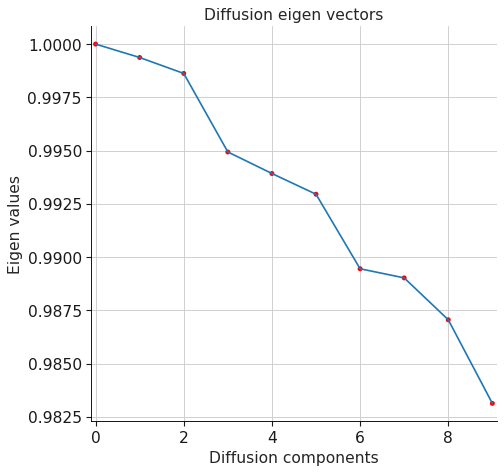

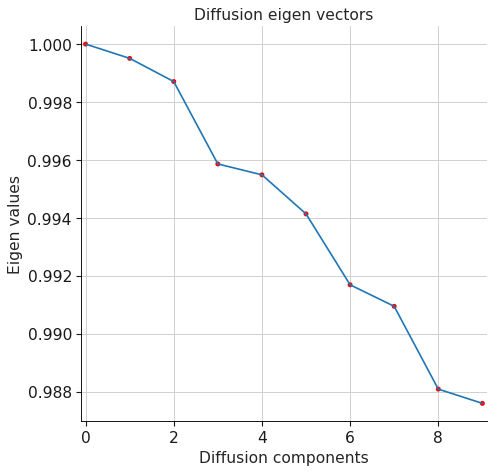

In [ ]:
print("For untreated B cells:")
basal_wb_surf.plot_diffusion_eigen_vectors()
print("For BCR treated B cells:")
bcr_wb_surf.plot_diffusion_eigen_vectors()

Text(0, 0.5, '142-CD19')

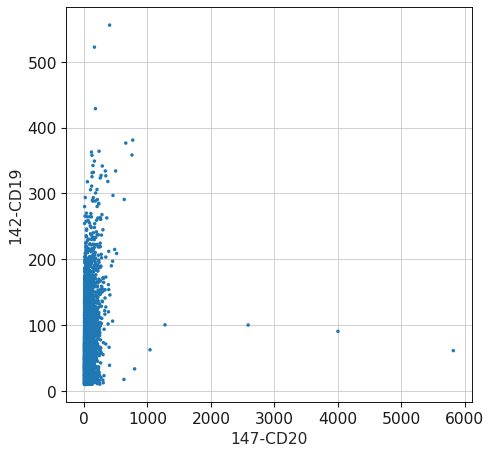

In [ ]:
fig, ax = wishbone.wb.get_fig()
plt.scatter(basal_wb_surf.data['147-CD20'], basal_wb_surf.data['142-CD19'], 
    s=10, edgecolors='none')
plt.xlabel('147-CD20')
plt.ylabel('142-CD19')

Text(0, 0.5, '142-CD19')

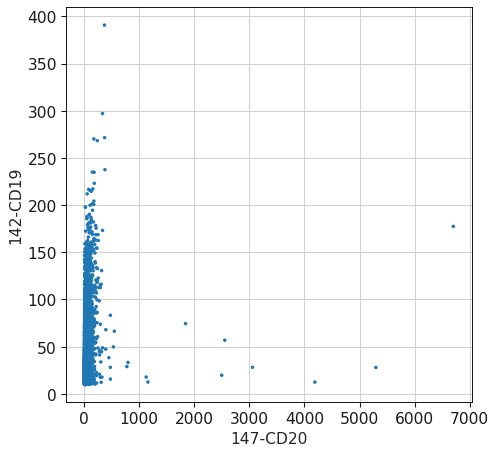

In [ ]:
fig, ax = wishbone.wb.get_fig()
plt.scatter(bcr_wb_surf.data['147-CD20'], bcr_wb_surf.data['142-CD19'], 
    s=10, edgecolors='none')
plt.xlabel('147-CD20')
plt.ylabel('142-CD19')

In [ ]:
# Start cell
basal_start_cell = basal_wb_surf.data.index[(basal_wb_surf.data['167-CD38'] > 3000)][0]

bcr_start_cell = bcr_wb_surf.data.index[(bcr_wb_surf.data['167-CD38'] > 3000)][0]

In [ ]:
basal_wb = wishbone.wb.Wishbone(basal_wb_surf)
basal_wb.run_wishbone(basal_start_cell, components_list=[1, 2, 3])

Building lNN graph...
lNN computed in : 0.09 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 214.49 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9993
1 realignment iterations


In [ ]:
basal_wb

Wishbone object: 14058 cells x 13 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

In [ ]:
bcr_wb = wishbone.wb.Wishbone(bcr_wb_surf)
bcr_wb.run_wishbone(bcr_start_cell, components_list=[1, 2])

Building lNN graph...
lNN computed in : 0.07 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 258.23 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  1.0000
1 realignment iterations


In [ ]:
bcr_wb

Wishbone object: 15644 cells x 13 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

**NOTE: Based on prior knowledge, the rise and fall of phenotypic B cell markers along the starts with with a decline in CD34 (which is a marker for Hematopietic Stem cells), followed by markers CD38; and then there is a change in the expression of CD19 and then CD20, and ending with immunoglobulin heavy chain IgH expression, indicative of immature B cells ready to leave the marrow.**

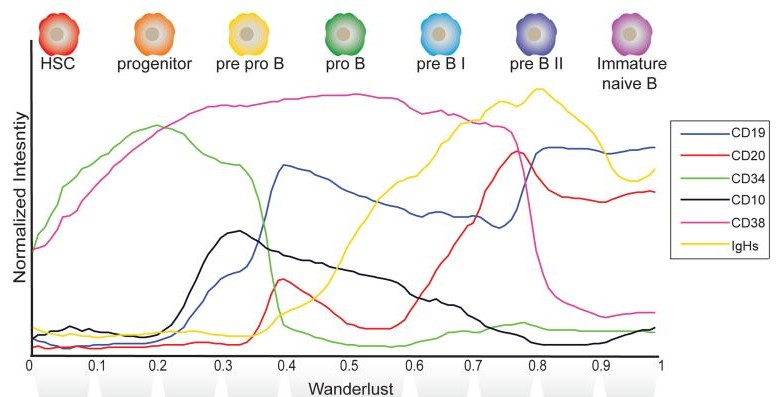

*Source: Bendall, S. C., Davis, K. L., Amir, e., Tadmor, M. D., Simonds, E. F., Chen, T. J., Shenfeld, D. K., Nolan, G. P., & Pe'er, D. (2014). Single-cell trajectory detection uncovers progression and regulatory coordination in human B cell development. Cell, 157(3), 714–725. https://doi.org/10.1016/j.cell.2014.04.005*

### Visualizing wishbone results for Surface Markers

Surface markers For Untreated B cells:


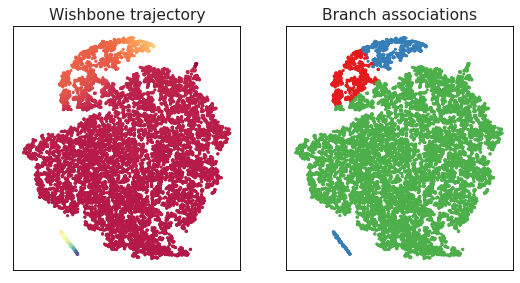

In [ ]:
print("Surface markers For Untreated B cells:")
fig, ax = basal_wb.plot_wishbone_on_tsne()

Surface markers For Untreated B cells:


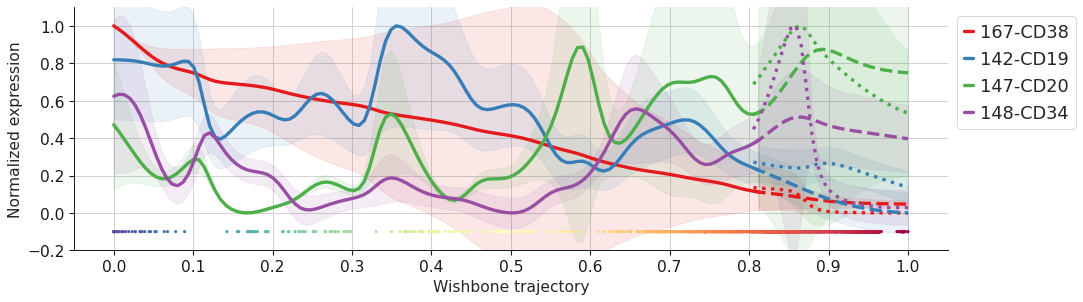

In [ ]:
print("Surface markers For Untreated B cells:")
vals, fig, ax = basal_wb.plot_marker_trajectory(['167-CD38', '142-CD19', '147-CD20', '148-CD34'], 
                    smoothing_factor=1.5, show_variance=True);

In [ ]:
bcr_wb.branch

12        3
30        3
45        3
73        3
94        3
         ..
471739    1
471770    3
471970    3
472012    3
472030    3
Length: 15644, dtype: int64

In basal, or untreated B cells, we see that as B cells move down the wishbone trajectory there is a decrease in CD38, and an increase in CD19 and CD20.

Surface Markers For BCR Treated B cells:


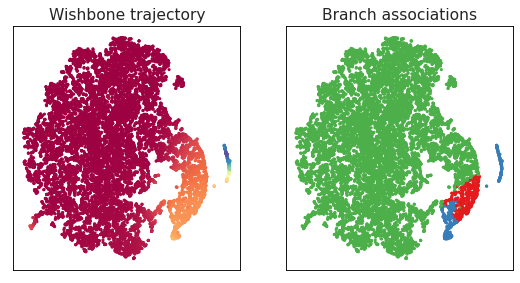

In [ ]:
print("Surface Markers For BCR Treated B cells:")
fig, ax = bcr_wb.plot_wishbone_on_tsne()

Surface markers For BCR Treated B cells:


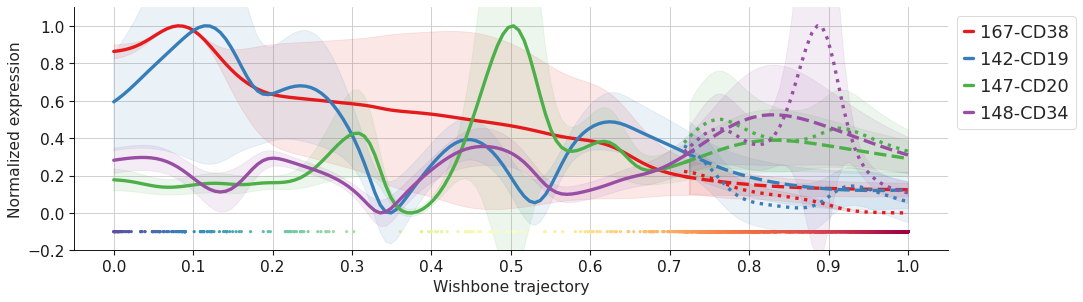

In [ ]:
print("Surface markers For BCR Treated B cells:")
vals, fig, ax = bcr_wb.plot_marker_trajectory(['167-CD38', '142-CD19', '147-CD20', '148-CD34'], 
                    smoothing_factor=1.5, show_variance=True);

# Trajectory Inference Analysis using Wishbone For **Signalling Proteins**

In [ ]:
# Create anndata object to apply scanpy 
basal_ioncount_sign = basal_sign
basal_adata_sign = anndata.AnnData(X = basal_ioncount_sign)
print(basal_adata_sign)

AnnData object with n_obs × n_vars = 14058 × 22


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
basal_X_sign = basal_adata_sign.X
basal_X_sign = pd.DataFrame(basal_X_sign, index=basal_adata_sign.obs.index, columns=basal_adata_sign.var.index)

In [ ]:
basal_X_sign = basal_adata_sign.X
basal_X_sign = pd.DataFrame(basal_X_sign, index=basal_adata_sign.obs.index, columns=basal_adata_sign.var.index)

In [ ]:
basal_wb_sign = wishbone.wb.SCData(basal_X_sign)

Target dimensionality reduced to 22.


(<Figure size 520x520 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f16122338d0>)

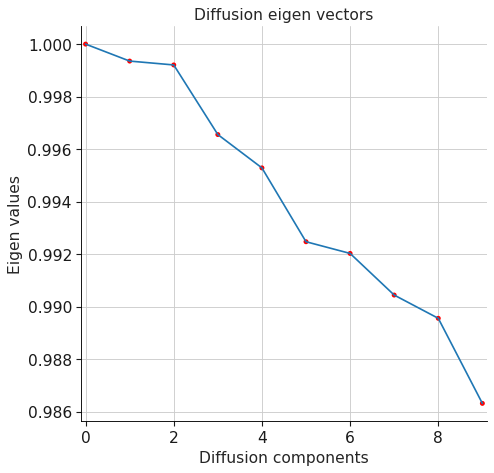

In [ ]:
basal_wb_sign = wishbone.wb.SCData(basal_X_sign)
basal_wb_sign.run_pca()
basal_wb_sign.run_tsne()
basal_wb_sign.run_diffusion_map()
basal_wb_sign.plot_diffusion_eigen_vectors()

In [ ]:
# Create anndata object to apply scanpy 
bcr_ioncount_sign = bcr_sign
bcr_adata_sign = anndata.AnnData(X = bcr_ioncount_sign)
print(bcr_adata_sign)

AnnData object with n_obs × n_vars = 15644 × 22


/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
bcr_X_sign = bcr_adata_sign.X
bcr_X_sign = pd.DataFrame(bcr_X_sign, index=bcr_adata_sign.obs.index, columns=bcr_adata_sign.var.index)

In [ ]:
bcr_X_sign = bcr_adata_sign.X
bcr_X_sign = pd.DataFrame(bcr_X_sign, index=bcr_adata_sign.obs.index, columns=bcr_adata_sign.var.index)

In [ ]:
bcr_wb_sign = wishbone.wb.SCData(bcr_X_sign)

Target dimensionality reduced to 22.


(<Figure size 520x520 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f161188fe50>)

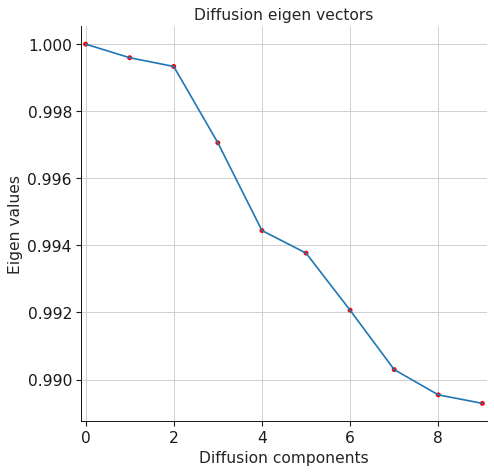

In [ ]:
bcr_wb_sign = wishbone.wb.SCData(bcr_X_sign)
bcr_wb_sign.run_pca()
bcr_wb_sign.run_tsne()
bcr_wb_sign.run_diffusion_map()
bcr_wb_sign.plot_diffusion_eigen_vectors()

In [ ]:
# Start cell
basal_start_cell_sign = basal_wb_sign.data.index[(basal_wb_sign.data['152-Ki67'] > 500)][0]
basal_wb = wishbone.wb.Wishbone(basal_wb_sign)
basal_wb.run_wishbone(basal_start_cell_sign, components_list=[1, 2, 3])
basal_wb 

Building lNN graph...
lNN computed in : 0.09 seconds
Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 231.31 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  0.9994
1 realignment iterations


Wishbone object: 14058 cells x 22 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

In [ ]:
# Start cell
bcr_start_cell_sign = bcr_wb_sign.data.index[(bcr_wb_sign.data['152-Ki67'] > 500)][0]
bcr_wb = wishbone.wb.Wishbone(bcr_wb_sign)
bcr_wb.run_wishbone(bcr_start_cell_sign, components_list=[1, 2])
bcr_wb

Building lNN graph...
lNN computed in : 0.07 seconds


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Determining waypoints if not specified...
Determining shortest path distances and perspectives....
..........................................................................................................................................................................................................................................................
Time for determining distances and perspectives: 240.71 seconds
Determining branch point and branch associations...
Running iterations...
Iteration: 2
Correlation with previous iteration:  1.0000
1 realignment iterations


Wishbone object: 15644 cells x 22 genes

branch=True
branch_colors=True
trajectory=True
waypoints=True

### Visualizing wishbone results for Signalling Proteins

Signalling proteins For Untreated B cells:


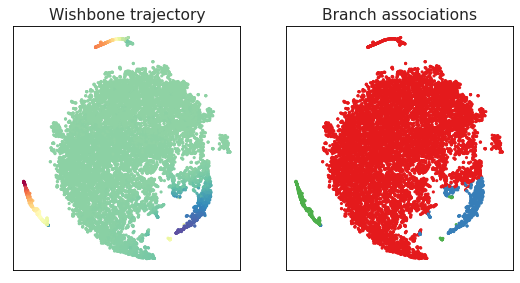

In [ ]:
print("Signalling proteins For Untreated B cells:")
fig, ax = basal_wb.plot_wishbone_on_tsne()

Signalling proteins For Untreated B cells:


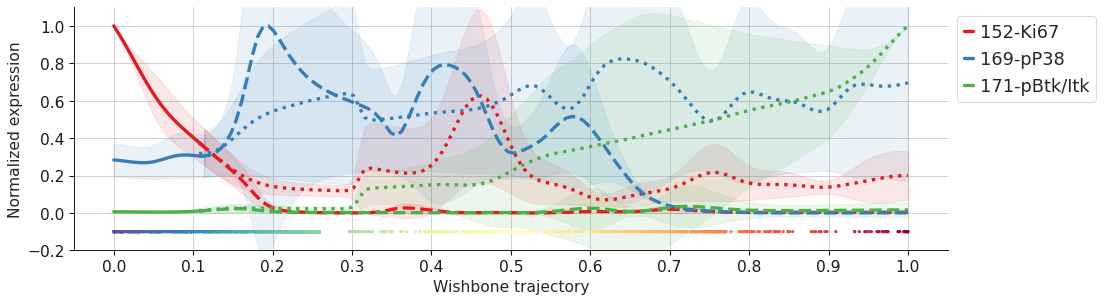

In [ ]:
print("Signalling proteins For Untreated B cells:")
vals, fig, ax = basal_wb.plot_marker_trajectory(['152-Ki67', '169-pP38', '171-pBtk/Itk'], 
                    smoothing_factor=1.5, show_variance=True);

Signalling proteins For BCR treated B cells:


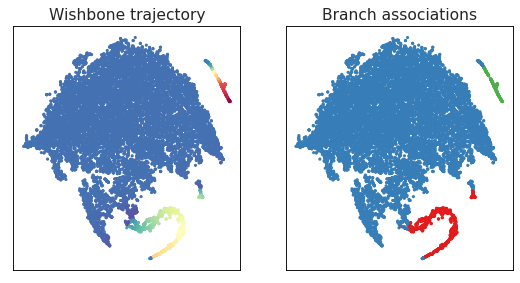

In [ ]:
print("Signalling proteins For BCR treated B cells:")
fig, ax = bcr_wb.plot_wishbone_on_tsne()

Signalling proteins For BCR treated B cells:


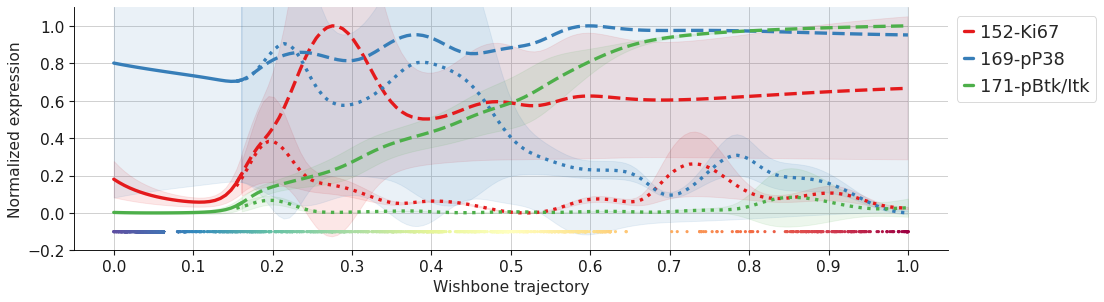

In [ ]:
print("Signalling proteins For BCR treated B cells:")
vals, fig, ax = bcr_wb.plot_marker_trajectory(['152-Ki67', '169-pP38', '171-pBtk/Itk'], 
                    smoothing_factor=1.5, show_variance=True);

# Excess Code

In [ ]:
#import numpy as np
#import pandas as pd
#pip install numpy --upgrade --ignore-installed --user

#pip install resource
#pip install wishbone

In [ ]:
#pip install numpy --upgrade --ignore-installed --user

In [ ]:
# source activate ml-genomics
# pip install wishbone
# pip install wishbone_dev

In [ ]:
#pip install resource

In [ ]:
#pip install setuptools
#pip install ez_setup